In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy 
from scipy.signal import welch
from colorsys import hls_to_rgb
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt

1.1: Реализация модели Курамото

In [2]:
class kuramoto:
    def __init__(self, t_max = 60, d_t = 0.01, K = 1.5, N = 500, sigma = 1, frequency = 10, simulation = "first"):
        self.K = K 
        self.N = N
        self.d_t = d_t
        self.sigma = sigma
        self.T = np.arange(0, t_max, d_t)
        self.timestamps = len(self.T) 
        self.init_state = np.random.uniform(-np.pi, np.pi, size = self.N)
     
        if simulation == "first":
            self.W = lambda t: np.random.uniform(0.75 * frequency, 1.25 * frequency, size=self.N)
        elif simulation == "second":
            self.W = self.second_W
        else:
            raise NotImplementedError 
                
    def second_W(self, t):      
        wf = [np.random.uniform(0.75 * freq, 1.25 * freq, size = self.N) for freq in [10, 20, 25, 10]]
        return wf[0] * (0 < t <= 15) + wf[1] * (15 < t <= 30) + wf[2] * (30 < t <= 45) + wf[3] * (45 < t <= 60)
    
    def theta(self):      
        theta = np.zeros((self.timestamps, self.N))
        theta[0, :] = self.init_state    
        for i, j in list(enumerate(self.T))[1:]:          
            delta = np.sin(deepcopy(theta[i-1, :]) - theta[i-1, :][np.newaxis, :])
            theta[i, :] = theta[i-1, :] + (2 * np.pi * self.W(j) + self.K / self.N * np.sum(delta, axis=1) + np.random.normal(0, self.sigma)) * self.d_t     
        return theta
    
    
    def result(self):
        theta = self.theta()
        ph_signal = np.mean(theta, axis = 1)
        signal = np.real(np.exp(1j*ph_signal))
        frequences, psd = welch(signal, fs=1/self.d_t, scaling="spectrum")
        return signal, frequences, psd

Функция извлечения значений сигналов, PSD и частот из симуляций

In [3]:
def psd(input):
    f, simulation = input
    model = kuramoto(frequency = f, simulation = simulation)
    signal, frequences, psd = model.result()
    return signal, frequences, psd

1.2: Симуляция 1

In [4]:
frequences = [10] * 10 + [15] * 5 + [25] * 5
with Parallel(cpu_count()) as pool:
    results1 = pool(delayed(psd)((f, "first")) for f in tqdm(frequences, leave=False))  

1.3: Симуляция 2

In [5]:
N_sim = 50
with Parallel(cpu_count()) as pool:
    results2 = pool(delayed(psd)((10, "second")) for f in tqdm(range(N_sim), leave=False))

2.1: графики PSD для симуляций 1 и 2

Text(0.5, 1.0, 'PSD')

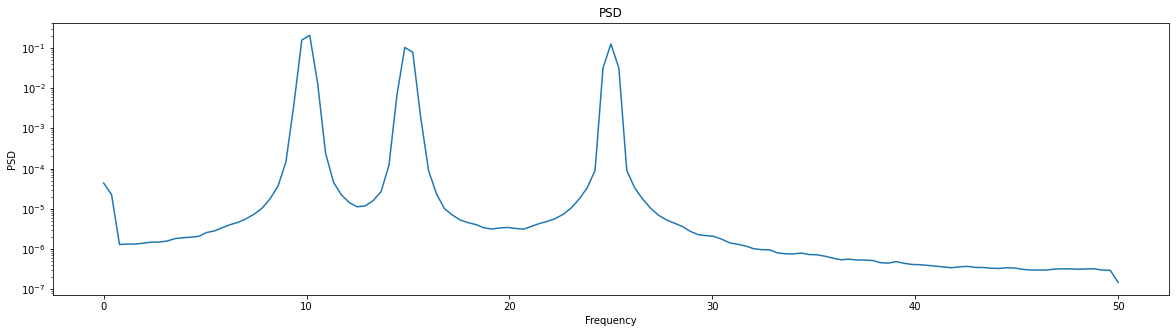

In [6]:
mean_freqs = np.mean([sim[1] for sim in results1], axis=0)
mean_psd = np.mean([sim[2] for sim in results1], axis=0)
plt.figure(figsize=(20, 5))
plt.semilogy(mean_freqs, mean_psd)
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.title('PSD')

Text(0.5, 1.0, 'PSD')

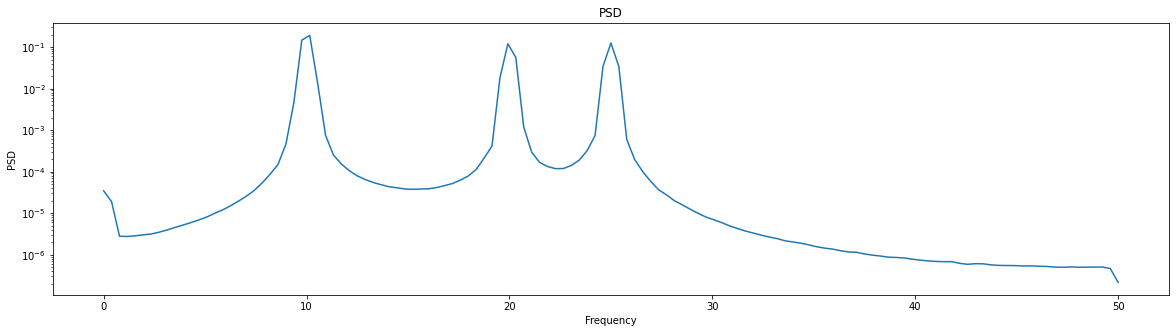

In [7]:
mean_freqs = np.mean([sim[1] for sim in results2], axis=0)
mean_psd = np.mean([sim[2] for sim in results2], axis=0)
plt.figure(figsize=(20, 5))
plt.semilogy(mean_freqs, mean_psd)
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.title('PSD')

2.2: Фазовая синхрония для сигналов в симуляции 1

In [8]:
def phases(data):
    f, simulation = data
    model = kuramoto(frequency = f, simulation = simulation)
    phases = model.theta()
    return phases

In [9]:
with Parallel(cpu_count()) as pool:
    results3 = pool(delayed(phases)((f, "first")) for f in tqdm(frequences, leave=False)) 

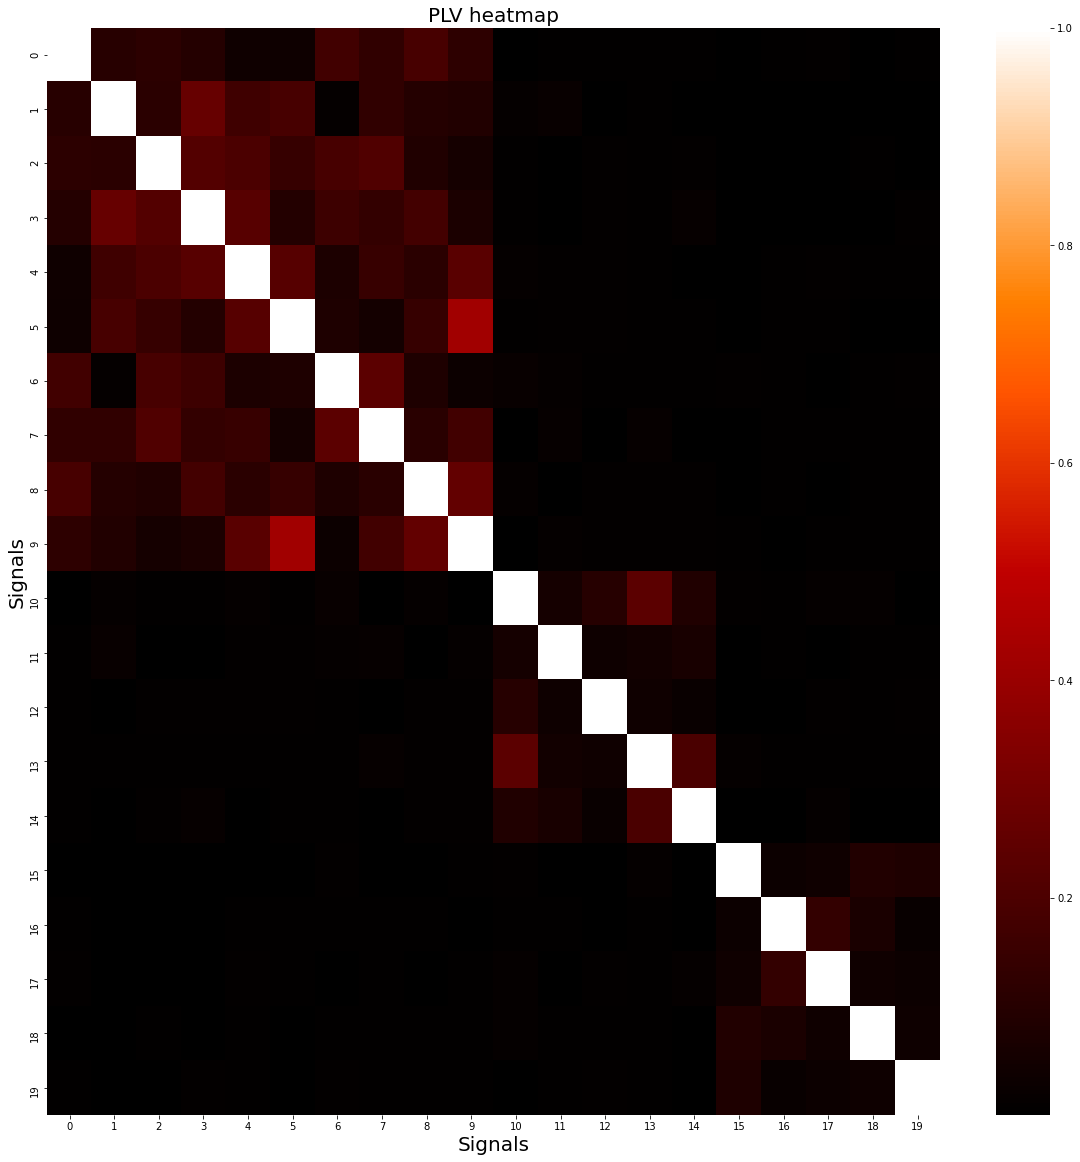

In [10]:
x = np.exp(1j * np.stack(results3, axis=0))
x = np.mean(x, axis=-1)
y = np.conj(x)
x /= np.abs(x)
y /= np.abs(y)
signals = np.abs((x @ y.T) / x.shape[1])

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(signals, cmap="gist_heat", ax=ax)
ax.set_xlabel('Signals', fontsize=20)
ax.set_ylabel('Signals', fontsize=20)
ax.set_title('PLV heatmap', fontsize=20)
plt.show()

2.3: PSD во времени для симуляции 2

(0.0, 60.0)

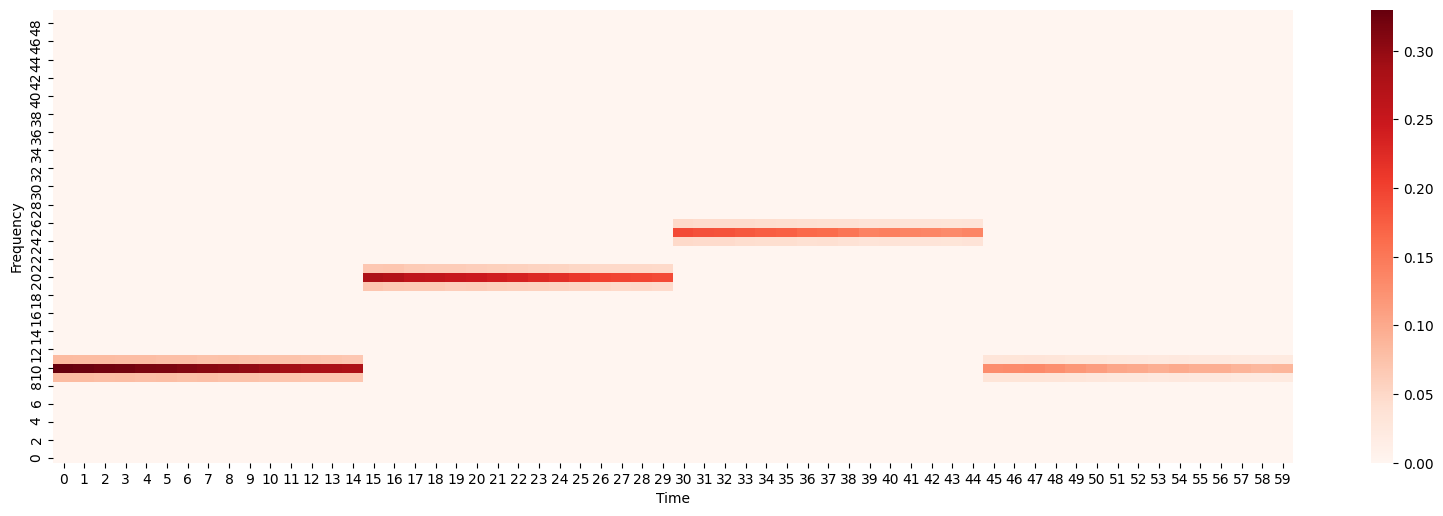

In [11]:
signal = np.mean([sim[0] for sim in results2], axis=0)
split = np.split(signal, len(signal)/100)
map = np.array([welch(s, fs=int(1/0.01), nperseg=len(s))[1] for s in split]).T

plt.figure(figsize=(20, 6), dpi=100)
sns.heatmap(map, cmap="Reds")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.ylim(0,50)
plt.xlim(0,60)